In [1]:
%load_ext autoreload
%autoreload 2

from tqdm import tqdm
import pandas as pd
import numpy as np
import gzip
import json
import math
from datetime import datetime
import seaborn as sns
import matplotlib.dates as mdates
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import display
%matplotlib inline
import pickle

import sys
sys.path.append('..')
from helper.rl_framework import *
from helper.orderbook_container import OrderbookContainer
from helper.manage_orderbooks import *
from helper.orderbook_trader import *
# from helper.RL_Agent import RLAgent
# from agents.NN_Agent import RLAgent_NN
from agents.BatchTree_Agent import RLAgent_BatchTree
from Runs.train_BatchTree import train_RL, trainer

In [3]:
V=100
T=4
P=15

filename_train = '/home/axel/data/small/obs_2016-11_USDT_BTC_maxVol100.dict'

actions = list(np.linspace(-0.4, 1.0, num=15))
print("Actions: ", ", ".join(["{:1.2f}".format(a) for a in actions]))

episodes_train = OrderbookEpisodesGenerator(filename=filename_train, episode_length=T*P)
print("Length of episodes_train: {}".format(len(episodes_train)))

Actions:  -0.40, -0.30, -0.20, -0.10, -0.00, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 1.00
Length of episodes_train: 541


### Settings

In [4]:
# cached_episodes = list(episodes_train[:20])
# pickle.dump( cached_episodes, open( "cached_episodes.p", "wb" ) )
data = pickle.load( open( "cached_episodes.p", "rb" ) )
data[0][0].timestamp

'2016-11-08T10:00'

RL-Type: <class 'agents.BatchTree_Agent.RLAgent_BatchTree'>


100%|██████████| 50/50 [00:12<00:00,  3.87it/s]


brain.samples.shape (1247, 8)


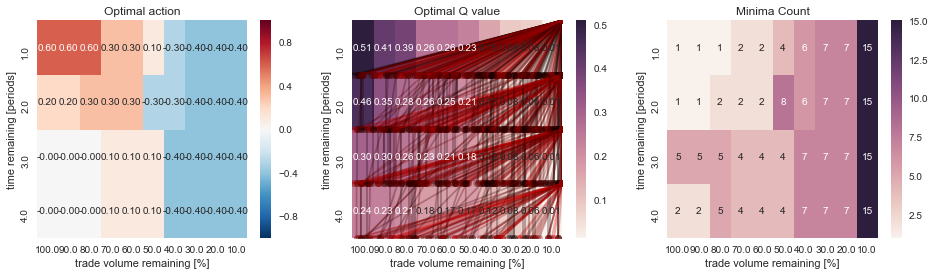

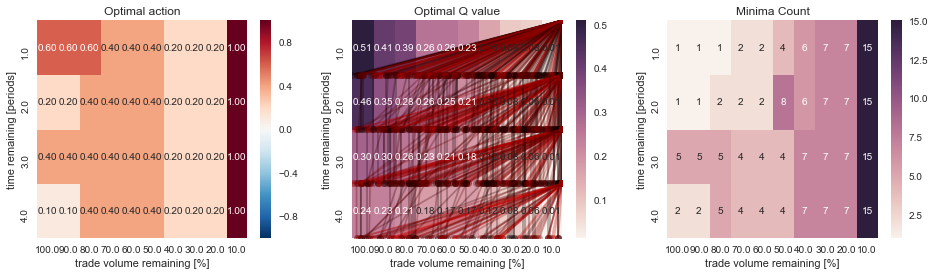

In [61]:
V=100
T=4
P=15

random.seed(13)
np.random.seed(13)
# plot_episode(episodes_train[1], volume=100)
data[0][0].timestamp
agent = trainer(orderbooks=data[:10], V=V, T=T, actions=actions,
                   period_length=P, epochs=50, random_start=True,
                   state_variables=['volume', 'time'])
agent.heatmap_Q(show_traces=True, which_min='first', show_minima_count=True)
agent.heatmap_Q(show_traces=True, which_min='last', show_minima_count=True)

n=1
n=2
n=3
n=4
n=5
n=6


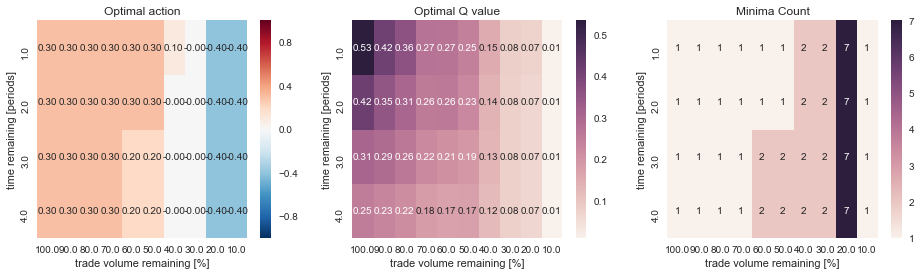

n=7


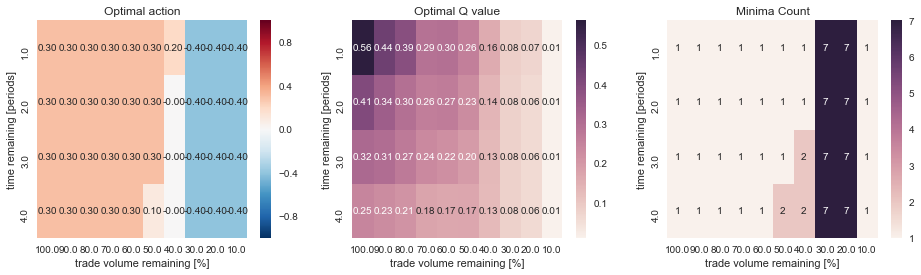

n=8


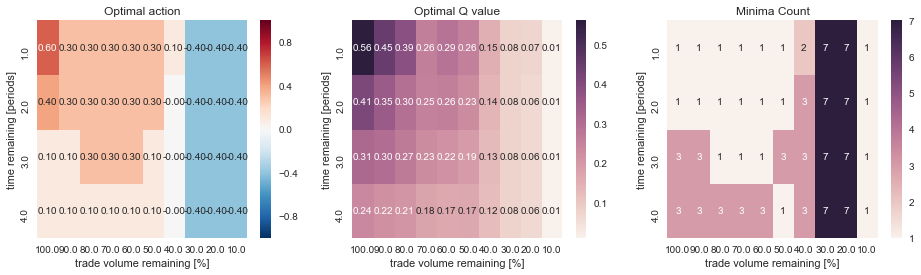

n=9


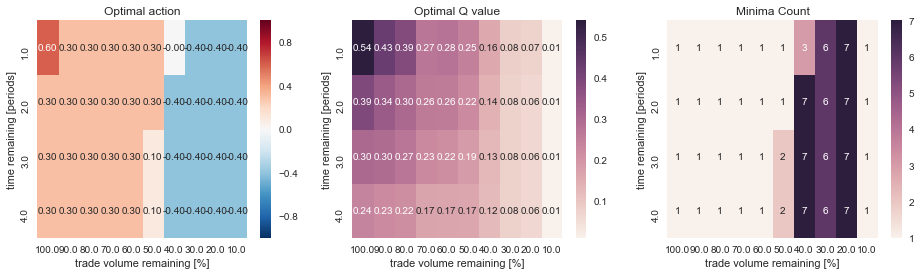

n=10


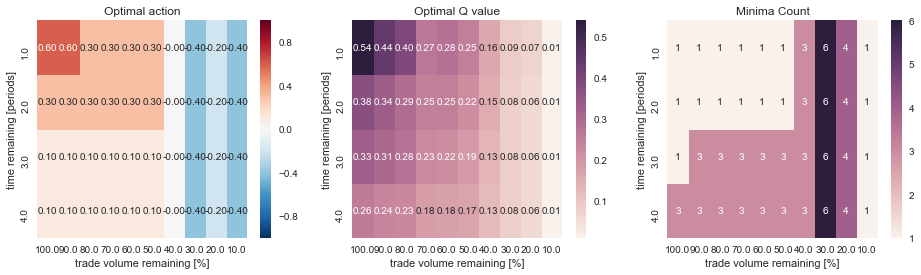

In [85]:
for n in range(1,11):
    print("n={}".format(n))
    agent.fitted_Q_iteration_tree(n)
    if n > 5:
        agent.heatmap_Q(show_traces=False, vol_intervals=10, which_min='first', show_minima_count=True)

In [84]:
costs = agent.evaluate(testdata=data[10:20], evaluate_actions=[0.4], costs=costs, name='Agent_10samples_deep')
display(costs)
display(costs.mean())

10it [00:18,  1.73s/it]


,BatchTree_Agent,0.4,Agent_10samples,Agent_10samples_last,Agent_10samples_deep
2016-11-08T20:01,0.277700,0.218356,0.081883,0.208137,0.172152
2016-11-08T21:01,0.259167,0.293760,0.249443,0.286355,0.277852
2016-11-08T22:01,0.100878,0.130666,0.369320,0.100878,0.163012
2016-11-08T23:01,0.164993,0.253480,0.150846,0.286188,0.249358
2016-11-09T00:01,0.173730,0.211489,0.266971,0.183448,0.179531
2016-11-09T01:01,0.299317,0.382596,0.345212,0.370185,0.565109
2016-11-09T02:01,0.058044,0.082392,0.031798,0.058044,0.170176
2016-11-09T03:01,0.799427,0.374530,0.999984,0.479219,0.348345
2016-11-09T04:01,1.214546,2.102771,2.183828,1.345685,1.441962
2016-11-09T05:01,0.079569,0.023436,0.420734,-0.011068,0.190707


BatchTree_Agent         0.342737
0.4                     0.407348
Agent_10samples         0.510002
Agent_10samples_last    0.330707
Agent_10samples_deep    0.375820
dtype: float64